In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
import time

import seaborn as sns

In [2]:
# parser v1
# parse records to list of dicts
# values mostly are strings
# easy to iterate through records
records = []
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        record = {}
        record['timestamp'] = int(components[0])
        record['displayed'] = components[1]
        record['clicked'] = int(components[2])
        # not using user feature
        record['user_features'] = []
        for i in range(4, len(components)):
            if components[i].startswith('|'):
                n = i
                break
            #record['user_features'].append(int(components[i]))
        record['pool'] = components[n:]    
        records.append(record)

In [3]:
len(records)

1607525

In [88]:
records[0]

{'clicked': 0,
 'displayed': 'id-560620',
 'pool': ['|id-552077',
  '|id-555224',
  '|id-555528',
  '|id-559744',
  '|id-559855',
  '|id-560290',
  '|id-560518',
  '|id-560620',
  '|id-563115',
  '|id-563582',
  '|id-563643',
  '|id-563787',
  '|id-563846',
  '|id-563938',
  '|id-564335',
  '|id-564418',
  '|id-564604',
  '|id-565364',
  '|id-565479',
  '|id-565515',
  '|id-565533',
  '|id-565561',
  '|id-565589',
  '|id-565648',
  '|id-565747',
  '|id-565822'],
 'timestamp': 1317513291,
 'user_features': []}

In [3]:
# parser that watches article lifespans
lives = {}
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        for component in components:
            if component.startswith('|id-'):
                timestamp = int(components[0])
                article = component[1:]
                if article in lives.keys():
                    lives[article][1] = timestamp
                else:
                    lives[article] = [timestamp, timestamp]

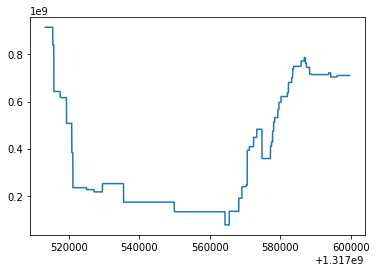

In [35]:
# life length variance along timespan
def get_life_length(x):
    lifespan = lives[x[1:]]
    return lifespan[1] - lifespan[0]
x = []
y = []
for record in records:
    x.append(record['timestamp'])
    y.append(np.var(list(map(lambda x:get_life_length(x), record['pool']))))
plt.plot(x,y)

In [145]:
# How many uncontinuous points
life = {}
uncontinuous = Counter()
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        timestamp = int(components[0])
        for component in components:
            if component.startswith('|id-'):
                article = component[4:]
                if article in life.keys():
                    if timestamp > life[article]+1:
                        uncontinuous[timestamp-life[article]-1] += 1
                life[article] = timestamp

In [146]:
uncontinuous

Counter({1: 434})

In [147]:
uncontinuous[1] / len(records)

0.00026998024914075985

In [55]:
# checking
l = {}
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        for component in components:
            if component.startswith('|id-'):
                timestamp = int(components[0])
                article = component[4:]
                if article in l.keys():
                    if l[article][-1] != timestamp:
                        l[article].append(timestamp)
                else:
                    l[article] = [timestamp]

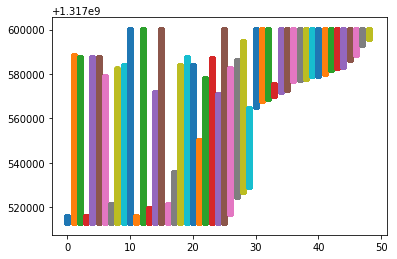

In [64]:
for n,i in enumerate(l.items()):
    plt.scatter([n]*len(i[1]), i[1])

In [100]:
lives.keys()

dict_keys(['id-552077', 'id-555224', 'id-555528', 'id-559744', 'id-559855', 'id-560290', 'id-560518', 'id-560620', 'id-563115', 'id-563582', 'id-563643', 'id-563787', 'id-563846', 'id-563938', 'id-564335', 'id-564418', 'id-564604', 'id-565364', 'id-565479', 'id-565515', 'id-565533', 'id-565561', 'id-565589', 'id-565648', 'id-565747', 'id-565822', 'id-565930', 'id-566013', 'id-566022', 'id-566092', 'id-560805', 'id-564371', 'id-562265', 'id-565980', 'id-566431', 'id-566439', 'id-559833', 'id-566541', 'id-562374', 'id-566587', 'id-566478', 'id-566573', 'id-566602', 'id-562637', 'id-566631', 'id-566689', 'id-566726', 'id-566825', 'id-566838'])

In [246]:
# average lifespan
sum(map(lambda x:x[1]-x[0], lives.values())) / len(lives)

40648.4693877551

In [9]:
life_length = []
alive = []
for v in lives.values():
    alive.append(np.arange(v[0], v[1]+1))
    life_length.append(v[1]-v[0])

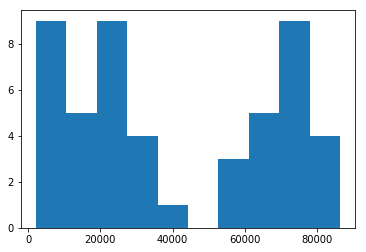

In [122]:
plt.hist(life_length)
pass

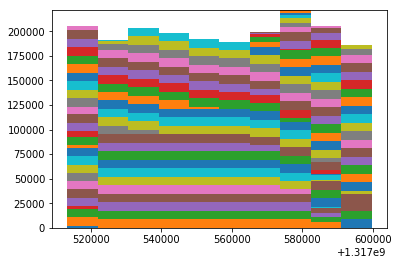

In [128]:
# number of arms available through out the timestamps
plt.hist(alive, histtype='barstacked')
pass

In [ ]:
estimated

In [65]:
records[0]['pool']

['|id-552077',
 '|id-555224',
 '|id-555528',
 '|id-559744',
 '|id-559855',
 '|id-560290',
 '|id-560518',
 '|id-560620',
 '|id-563115',
 '|id-563582',
 '|id-563643',
 '|id-563787',
 '|id-563846',
 '|id-563938',
 '|id-564335',
 '|id-564418',
 '|id-564604',
 '|id-565364',
 '|id-565479',
 '|id-565515',
 '|id-565533',
 '|id-565561',
 '|id-565589',
 '|id-565648',
 '|id-565747',
 '|id-565822']

In [7]:
# offline simulation for AG_L
# slow but more accurate version
# comsumes much more records


def AG_L2(n=1000,k=1, m=25, life_threshold=.1, records=records, lives=lives, verbose=True):
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    def get_young_arms():
        time = records[i]['timestamp']
        born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
        life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
        young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
        return list(zip(*young))[0]
    
    def get_best_arm():
        time = records[i]['timestamp']
        available = filter(lambda x:lives[x[0]][1] >= time, X.items())
        best = max(available, key= lambda x:x[1][0]/x[1][1])
        return best
    
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        record = records[i]
        displayed = record['displayed']
        clicked = record['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    try:
        while t<=n:
            best = get_best_arm()
            X_max = best[1][0]/best[1][1]
            if np.random.binomial(1, min(1, X_max*k)): # exploit
                n_exploit += 1
                while records[i]['displayed'] != get_best_arm()[0]:
                    i += 1
            else: # explore
                n_explore += 1
                while records[i]['displayed'] != np.random.choice(get_young_arms(), size=1):
                    i += 1
                    
            if verbose:
                if i%1000==0:
                    print(t, i)
                
            record = records[i]
            rewards += record['clicked']
            X[record['displayed']] = X.get(record['displayed'], np.array([0, 0])) + np.array([record['clicked'], 1])
            t += 1
            i += 1
            
    except IndexError:
        print('running out of records')
        return
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)


    return rewards

In [8]:
AG_L2(10000, life_threshold=.1)

619 16000
654 17000
2060 54000
2627 67000
2714 69000
2944 74000
3347 83000
4355 107000
5522 135000
6748 163000
6936 167000
7646 182000
8112 192000
8260 195000
# exploit: 568
# explore: 9407
# records: 231711
max expectation: 0.04746222394420767


454

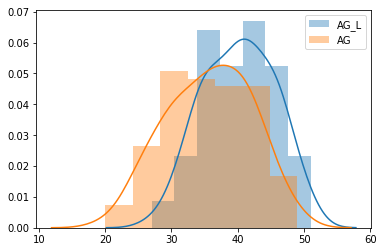

In [72]:
# compare by birth
agl = []
ag = []
for i in range(100):
    agl.append(AG_L2(n=1000, life_threshold=.5, verbose=False))
    ag.append(AG_L2(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

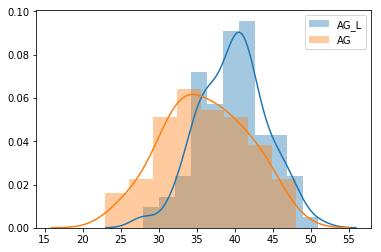

In [70]:
# compare by birth
agl = []
ag = []
for i in range(100):
    agl.append(AG_L2(n=1000,verbose=False))
    ag.append(AG_L2(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

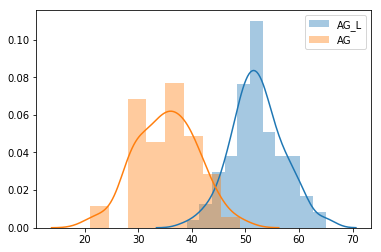

In [30]:
# knows exact lifespans
agl = []
ag = []
for i in range(100):
    agl.append(AG_L2(n=1000,verbose=False))
    ag.append(AG_L2(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

In [5]:
# offline simulation for AG_L
# fast version, consumes much less records
def AG_L(n=1000000,k=1, m=25, life_threshold=.3, records=records, lives=lives, verbose=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        try:
            displayed = records[i]['displayed']
            clicked = records[i]['clicked']
        except IndexError:
            print('running out of records')
            print(t,i)
            raise IndexError
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    while t<=n:
        best = max(X.items(), key= lambda x:x[1][0]/x[1][1])
        X_max = best[1][0]/best[1][1]
        if np.random.binomial(1, min(1, X_max*k)): # exploit
            n_exploit += 1                       
            while i < len(records): # look for target arm
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                if displayed == best[0]:
                    rewards += clicked
                    break
                i += 1
                
        else: # explore
            n_explore += 1           
            while i < len(records):
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                time = records[i]['timestamp']
                born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
                life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
                young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
                if displayed in list(zip(*young))[0]:
                    rewards += clicked
                    break
                i += 1

        X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
        t += 1
        i += 1
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)
    
    return rewards

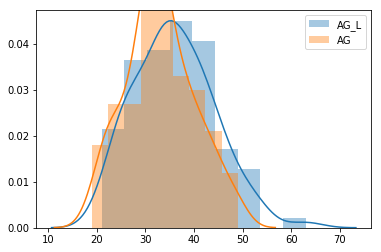

In [38]:
# knows exact lifespans
# play i different games
agl = []
ag = []
for i in range(100):
    agl.append(AG_L(n=1000, m=20, records=records[i*10000:100000+i*10000], verbose=False))
    ag.append(AG_L(n=1000, m=20, records=records[i*10000:100000+i*10000], life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

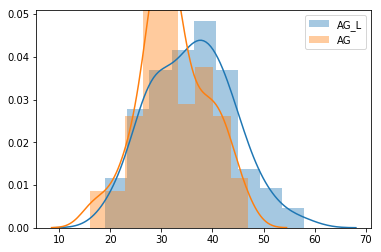

In [99]:
# knows exact lifespans
# play i different games
agl = []
ag = []
for i in range(100):
    agl.append(AG_L(n=1000, m=20, records=records[i*10000:100000+i*10000], verbose=False))
    ag.append(AG_L(n=1000, m=20, records=records[i*10000:100000+i*10000], life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

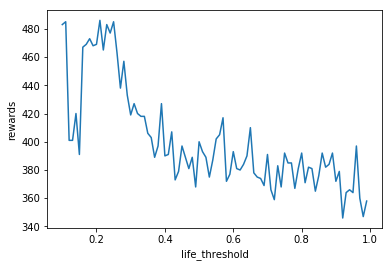

In [35]:
x = []
y = []
for b in np.arange(0.1,1.,.01):
    x.append(b)
    y.append(AG_L(n=10000,life_threshold=b, verbose=False))
plt.plot(x,y)
plt.xlabel('life_threshold')
plt.ylabel('rewards')
pass

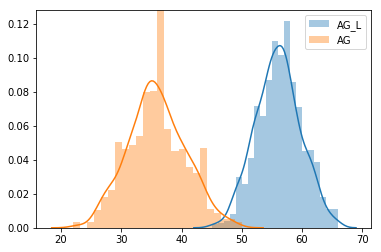

In [84]:
agl = []
ag = []
for i in range(1000):
    agl.append(AG_L(n=1000,verbose=False))
    ag.append(AG_L(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

In [17]:
# offline simulation for UCB_L
def UCB_L(n=1000, c=.005, m=25, r=1, records=records, lives=lives, verbose=True, mode=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    mode: whether the modification is active or not
    '''
    def ucb(x):
        # r: ratio between paces of timestamp and turns
        time = records[i]['timestamp']
        article = x[0]
        acc_reward, T = x[1]
        die = lives[article][1]
        s = S.get(article, t)
        if mode:
            return acc_reward/T + c*np.log(r*(die-time)+1) * np.sqrt(2*np.log(t-s+1) / T)
        else:
            return acc_reward/T + np.sqrt(2*np.log(t-s+1)/T)
        
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    S = {} # records the first turn an arm is played
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            S[displayed] = t
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    while t<=n:
        while i<len(records):
            fake = False
            displayed = records[i]['displayed']
            clicked = records[i]['clicked']
            
            if displayed not in X.keys(): # use previous mean as an estimation for an unseen arm
                fake = True
                estimation = sum(map(lambda x:x[0]/x[1], X.values())) / len(X) 
                X[displayed] = np.array([estimation, 1])
                            
            best = max(X.items(), key= lambda x:ucb(x))
            
            if fake:
                X.pop(displayed)

            if displayed == best[0]:
                rewards += clicked
                if displayed not in S.keys(): # the first time an arm is played
                    S[displayed] = t
                X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
                break
            i += 1
            
        if i>=len(records):
            print('running out of records')
            return
        
        if verbose:       
            if i%1000==0:
                print(t,i)
            
        t += 1
        i += 1
    if verbose:
        print('# X', len(X.keys()))
        print('# records', i)
        return rewards, X
    return rewards

In [20]:
# tune rewards
def UCB_L2(n=1000, c=.005, m=25, r=1, reward_rate=1, records=records, lives=lives, verbose=True, mode=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    mode: whether the modification is active or not
    '''
    def ucb(x):
        # r: ratio between paces of timestamp and turns
        time = records[i]['timestamp']
        article = x[0]
        acc_reward, T = x[1]
        die = lives[article][1]
        s = S.get(article, t)
        if mode:
            return acc_reward/T + c*np.log(r*(die-time)+1) * np.sqrt(2*np.log(t-s+1) / T)
        else:
            return acc_reward/T + np.sqrt(2*np.log(t-s+1)/T)
        
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    S = {} # records the first turn an arm is played
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked'] * reward_rate
        if displayed not in X.keys():
            S[displayed] = t
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    while t<=n:
        while i<len(records):
            fake = False
            displayed = records[i]['displayed']
            clicked = records[i]['clicked'] * reward_rate
            
            if displayed not in X.keys(): # use previous mean as an estimation for an unseen arm
                fake = True
                estimation = sum(map(lambda x:x[0]/x[1], X.values())) / len(X) 
                X[displayed] = np.array([estimation, 1])
                            
            best = max(X.items(), key= lambda x:ucb(x))
            
            
            if fake:
                X.pop(displayed)

            if displayed == best[0]:
                rewards += clicked
                if displayed not in S.keys(): # the first time an arm is played
                    S[displayed] = t
                X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
                break
            i += 1
            
        if i>=len(records):
            print('running out of records')
            return
        
        if verbose:       
            if i%1000==0:
                print(t,i)
            
        t += 1
        i += 1
    if verbose:
        print('# X', len(X.keys()))
        print('# records', i)
        return rewards, X
    return rewards

In [44]:
UCB_L2(reward_rate=100,c=10, verbose=False)/100

43.0

In [42]:
UCB_L2(reward_rate=50, c=5, verbose=False)/50

43.0

In [43]:
UCB_L2(reward_rate=10, c=5, verbose=False)/10

31.0

In [36]:
UCB_L2(reward_rate=10, c=.5, verbose=False)/10

39.0

In [27]:
UCB_L2(reward_rate=5, verbose=False)/5

49.0

In [31]:
UCB_L2(reward_rate=1, c=.005, verbose=False)

47

In [48]:
UCB_L2(reward_rate=.1, c=.001, verbose=False)/.1

39.00000000000002

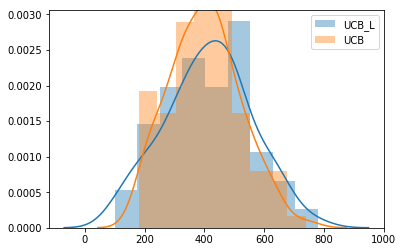

In [22]:
ucbl = []
ucbn = []
for i in range(100):
    ucbl.append(UCB_L2(n=500, m=20, r=.8, reward_rate=20, c=0.005, records=records[i*300:1000000+i*300], verbose=False))
    ucbn.append(UCB_L2(n=500, m=20, r=.8, reward_rate=20, records=records[i*300:1000000+i*300], mode=False, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(ucbl,label='UCB_L')
sns.distplot(ucbn,label='UCB')
plt.legend()
pass

In [5]:
rewards,X = UCB_L()

# X 25
# records 24479


In [16]:
len(X)

25

In [15]:
for i in X:
    print(i, X[i], lives[i][1]-lives[i][0])
# id [totalRewards timesPlayed] lifeLength

id-560620 [0 6] 7808
id-565648 [0 9] 73508
id-563115 [ 2 51] 68708
id-552077 [0 4] 2108
id-564335 [0 9] 57908
id-565589 [0 9] 64208
id-563938 [ 1 27] 6008
id-560290 [ 1 32] 73808
id-563643 [ 0 10] 86403
id-565822 [ 0 10] 86403
id-563787 [ 1 25] 2408
id-555528 [0 9] 73808
id-565364 [ 1 29] 22208
id-559855 [0 9] 73808
id-560518 [0 9] 65108
id-565561 [0 8] 36608
id-564604 [0 6] 7508
id-563846 [ 0 10] 86403
id-563582 [ 1 32] 70508
id-565533 [ 3 69] 70208
id-565479 [0 9] 70208
id-559744 [0 4] 2408
id-565515 [ 38 595] 74108
id-564418 [ 0 10] 86403
id-565747 [0 9] 57008


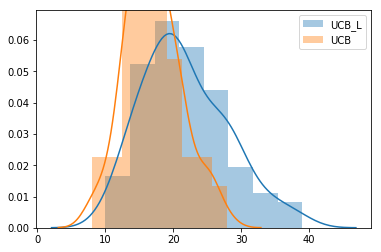

In [139]:
ucbl = []
ucbn = []
for i in range(100):
    ucbl.append(UCB_L(n=500, m=20, r=.8, c=0.005, records=records[i*300:1000000+i*300], verbose=False))
    ucbn.append(UCB_L(n=500, m=20, r=.8, records=records[i*300:1000000+i*300], mode=False, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(ucbl,label='UCB_L')
sns.distplot(ucbn,label='UCB')
plt.legend()
pass

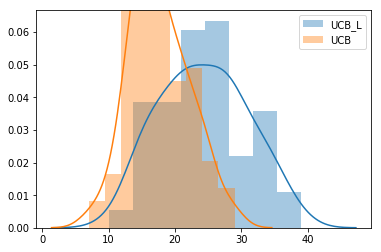

In [18]:
ucbl = []
ucbn = []
for i in range(100):
    ucbl.append(UCB_L(n=500, m=20, r=.8, c=0.005, records=records[i*100:1000000+i*100], verbose=False))
    ucbn.append(UCB_L(n=500, m=20, r=.8, records=records[i*100:1000000+i*100], mode=False, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(ucbl,label='UCB_L')
sns.distplot(ucbn,label='UCB')
plt.legend()
pass

In [144]:
from collections import Counter

In [25]:
c=Counter()
i=0
while i<len(records):
    c[records[i]['clicked']] += 1
    i += 1
c

Counter({0: 1552903, 1: 54622})

In [28]:
c[1]/(c[0]+c[1])

0.03397894278471563